In [1]:
import pandas as pd
import numpy as np 
import wrangle
import seaborn as sns
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")


# import and prepare the data
- data acquired from local csv file, which was downloaded from kaggle
- added rank, tier, and is successful columns to the csv file
- dropped the wallpaper, birthday, catchphrase, flooring, furniture, filename, and unique entry id
-got rid of spaces  in the column names
- manually filled in the null data from the animal crossing webpage
    -included 22 characters that were missing from the original csv file, but were on the tier list

In [2]:
# import the data from local csv
df = wrangle.get_acnh_data()

In [3]:
df.head()

,Rank,Tier,Species,Gender,Personality,Hobby,Birthday,Catchphrase,Favorite Song,Style 1,Style 2,Color 1,Color 2,Wallpaper,Flooring,Furniture List,Filename,Unique Entry ID
Name,,,,,,,,,,,,,,,,,,
Marshal,1,1,Squirrel,Male,Smug,Music,29-Sep,sulky,K.K. Bossa,Elegant,Cool,Light blue,Blue,blue delicate-blooms wall,modern wood flooring,2554;1081;3681;9766;1161;3615;1845;8394;3271;3...,squ17,ZZJJbE5zFrcDXfLEF
Raymond,2,1,Cat,Male,Smug,Nature,1-Oct,crisp,K.K. Cruisin',Elegant,Cool,Black,Gray,office wall,monochromatic tile flooring,840;4116;1750;3590;1232;832;3560;839;3784;1744...,cat23,2nbzgWsuDBSN2LeEj
Shino,3,1,Deer,Female,Peppy,Education,31-Oct,okaaay,K.K. Folk,Elegant,Gorgeous,Red,Black,NaN,NaN,NaN,NaN,NaN
Sasha,4,1,Rabbit,Male,Lazy,Fashion,19-May,hoppity,K.K Robot Synth,Simple,Cute,Blue,White,NaN,NaN,NaN,NaN,NaN
Zucker,5,1,Octopus,Male,Lazy,Nature,8-Mar,bloop,Spring Blossoms,Simple,Cute,Blue,Yellow,chain-link fence,backyard lawn,4042;4412;7526;4077;4077;3064;4077;3946;3617;3...,ocp02,2F5tipHqgmWvWXTLC


In [4]:
# prepare the data using wrangle file 
df = wrangle.prep_acnh_data(df)

In [5]:
df.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Marshal,1,1,Squirrel,Male,Smug,Music,K.K. Bossa,Elegant,Cool,Light blue,Blue,1
Raymond,2,1,Cat,Male,Smug,Nature,K.K. Cruisin',Elegant,Cool,Black,Gray,1
Shino,3,1,Deer,Female,Peppy,Education,K.K. Folk,Elegant,Gorgeous,Red,Black,1
Sasha,4,1,Rabbit,Male,Lazy,Fashion,K.K Robot Synth,Simple,Cute,Blue,White,1
Zucker,5,1,Octopus,Male,Lazy,Nature,Spring Blossoms,Simple,Cute,Blue,Yellow,1


In [6]:
df.shape

(413, 12)

In [7]:
#ensure that the is successful worked properly
df.is_successful.value_counts()

0    343
1     70
Name: is_successful, dtype: int64

- testing function to put into wrangle file


def successful(tier):
    if tier == 1 or tier == 2 or tier == 3:
        return 1
    else:
        return 0
    

- applying function to df to ensure it works

df["successful"] = df["tier"].apply(lambda tier: successful(tier))

In [8]:
# success is defined as being in the top 3 tiers. these 3 tiers account for the top 17% of the characters
df.tier.value_counts()

6    163
5    120
4     60
3     30
2     25
1     15
Name: tier, dtype: int64

In [9]:
70 / 413

0.1694915254237288

In [10]:
def split_acnh_data(df):

    train_validate, test = train_test_split(df, test_size=.2, 
        random_state=123)

    train, validate = train_test_split(train_validate, test_size=.3, 
        random_state=123)
    return train, validate, test


In [11]:
train, validate, test = split_acnh_data(df)

In [12]:
train.shape, validate.shape, test.shape

((231, 12), (99, 12), (83, 12))

### some points to make before starting exploration

- Being in tier 1, 2, or 3 determines whether or not a character is successful
    - this corresponds with a rank between 1-70, with a rank higher than 70 being in a lower rank and thus unsuccessful
- i'm not seeing these as characters in a game, but rather products and attributes of the products

- I want to see what possible attributes could be influencing the popularity of these products and, hopefully, make recommendations on what attributes we can combine in the future to make products that are more likely to be popular. 

- I also want to test whether a new, unseen, character would be successful based on the combination of attributes that it is given

- Key point in this project is that i will not be using "cuteness" of a character as a factor, since "cuteness" is a matter of personal opinion so there is no real way to measure it. Plus some things are so ugly they can be cute. Additionally, there are some characters that can be considered cute that aren't successful and there are some characters that are not considered cute that do well. 

- another side factor to consider is that color_1 is typically the color of the characters clothes. 

- I am leaving in favorite song, since it will be playing in the character's house. If a song really annoys a person, they could be less apt to keep that character. 

# Exploration

### initial hypotheses: 
- the species, hobby, and color_1 play a large part on whether or not a character will be successful
- while favorite_song might play a roll, i don't know that it will be significant enough to determine whether a character will be successful
- the style of the character will also play a role, since this will be tied in with how they look


In [13]:
df.gender.value_counts()

Male      214
Female    199
Name: gender, dtype: int64

In [14]:
train.groupby('is_successful').gender.value_counts()


is_successful  gender
0              Male      105
               Female     89
1              Female     21
               Male       16
Name: gender, dtype: int64

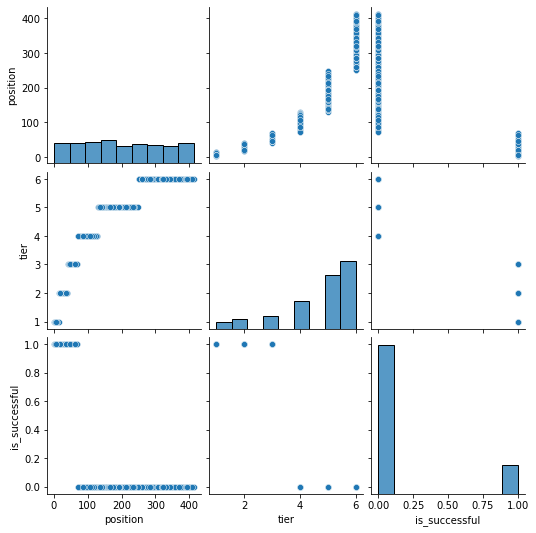

In [15]:
sns.pairplot(train)

In [16]:
train.dtypes

position          int64
tier              int64
species          object
gender           object
personality      object
hobby            object
favorite_song    object
style_1          object
style_2          object
color_1          object
color_2          object
is_successful     int64
dtype: object

In [17]:
train.head()

,position,tier,species,gender,personality,hobby,favorite_song,style_1,style_2,color_1,color_2,is_successful
Name,,,,,,,,,,,,
Toby,387,6,Rabbit,Male,Smug,Music,King K.K.,Cute,Elegant,Green,Orange,0
Bubbles,197,5,Hippo,Female,Peppy,Fashion,K.K. Stroll,Active,Cute,Purple,Pink,0
Chester,347,6,Cub,Male,Lazy,Play,Imperial K.K.,Simple,Simple,Yellow,Green,0
Rodney,231,5,Hamster,Male,Smug,Music,K.K. Rockabilly,Gorgeous,Cool,Pink,Colorful,0
Teddy,86,4,Bear,Male,Jock,Fitness,Mr. K.K.,Simple,Simple,Yellow,Orange,0


testing_rename = train.rename(columns={'rank':'position'})

testing_rename.head(1)

In [18]:
overall_mean= train.position.mean()

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

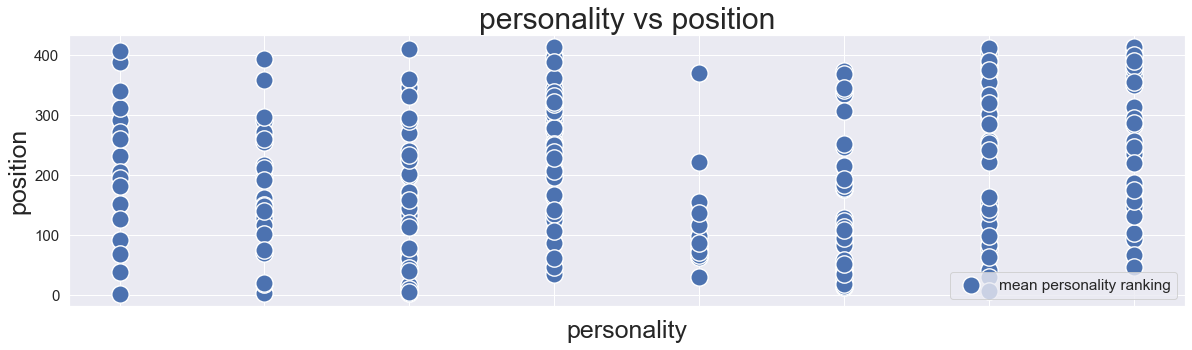

In [19]:
plt.figure(figsize=(20,5))
sns.set(font_scale = 1.4)
ax = sns.scatterplot(x='personality', y = 'position', data = train, label = 'mean personality ranking', s = 300)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("personality vs position", fontsize = 30)
plt.xlabel("personality",fontsize=25)
plt.ylabel("position", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


<AxesSubplot:ylabel='is_successful,gender'>

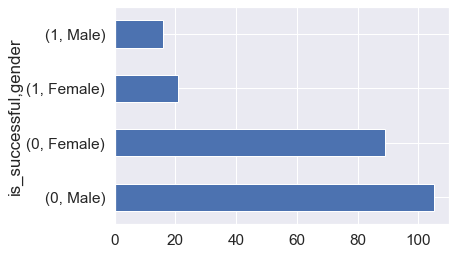

In [20]:
train.groupby('is_successful').gender.value_counts().plot.barh()

<AxesSubplot:xlabel='personality', ylabel='position'>

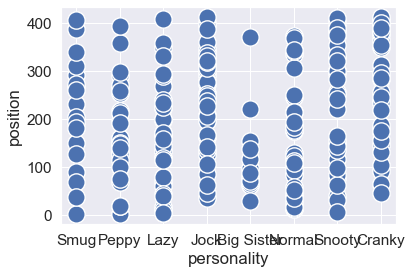

In [21]:
sns.scatterplot(x='personality', y = 'position' , data = train, s = 300)

(array([-100.,    0.,  100.,  200.,  300.,  400.,  500.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

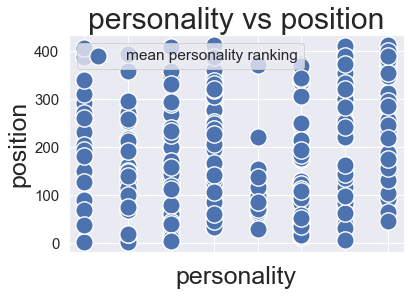

In [22]:
ax = sns.scatterplot(x='personality', y = 'position', data = train, label = 'mean personality ranking', s = 300)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)
ax.set_title("personality vs position", fontsize = 30)
plt.xlabel("personality",fontsize=25)
plt.ylabel("position", fontsize=25)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)


In [23]:
species_ranking = train.groupby('species').mean()['position'].to_frame().reset_index().sort_values('position')

In [24]:
species_ranking

,species,position
25,Octopus,25.50
9,Deer,69.00
5,Cat,81.07
34,Wolf,81.40
15,Goat,114.00
29,Rabbit,136.44
10,Dog,143.33
32,Squirrel,164.43
17,Hamster,171.14
8,Cub,171.80


<AxesSubplot:xlabel='species', ylabel='position'>

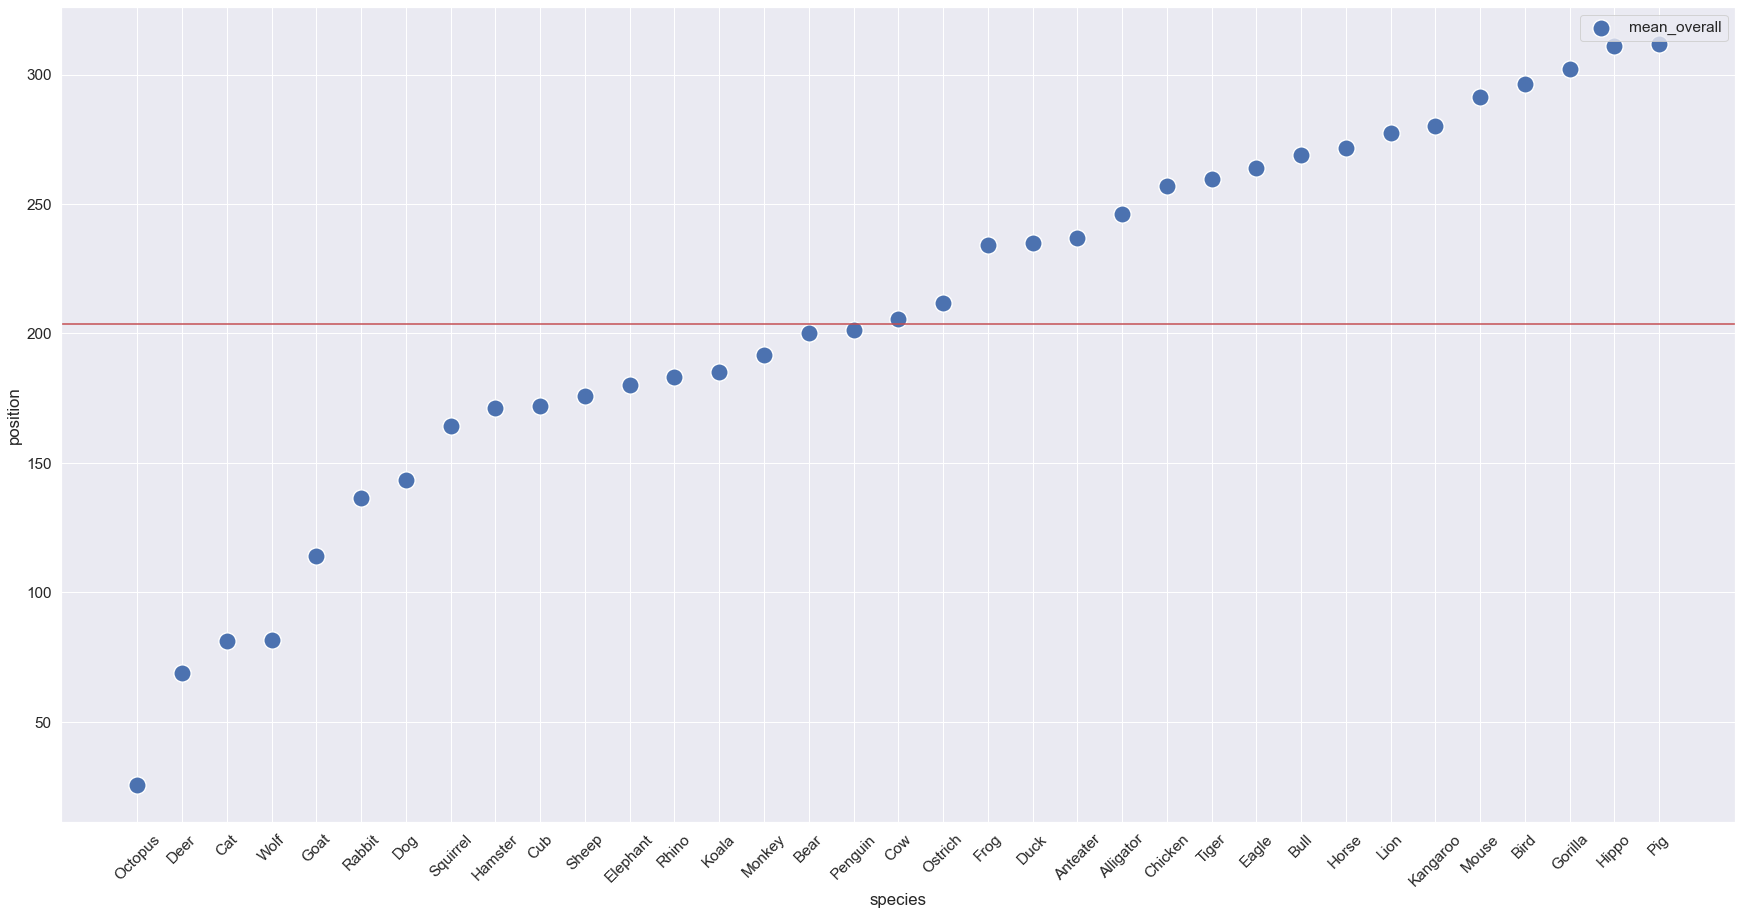

In [25]:
plt.figure(figsize=(30,15))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='species', y="position", data=species_ranking,label='mean_overall', s=300)

In [26]:
personality_ranking = train.groupby('personality').mean()['position'].to_frame().reset_index().sort_values('position')

In [27]:
personality_ranking

,personality,position
0,Big Sister,118.57
4,Normal,158.97
3,Lazy,164.55
5,Peppy,177.31
6,Smug,212.39
2,Jock,240.79
7,Snooty,242.86
1,Cranky,259.23


<AxesSubplot:xlabel='personality', ylabel='position'>

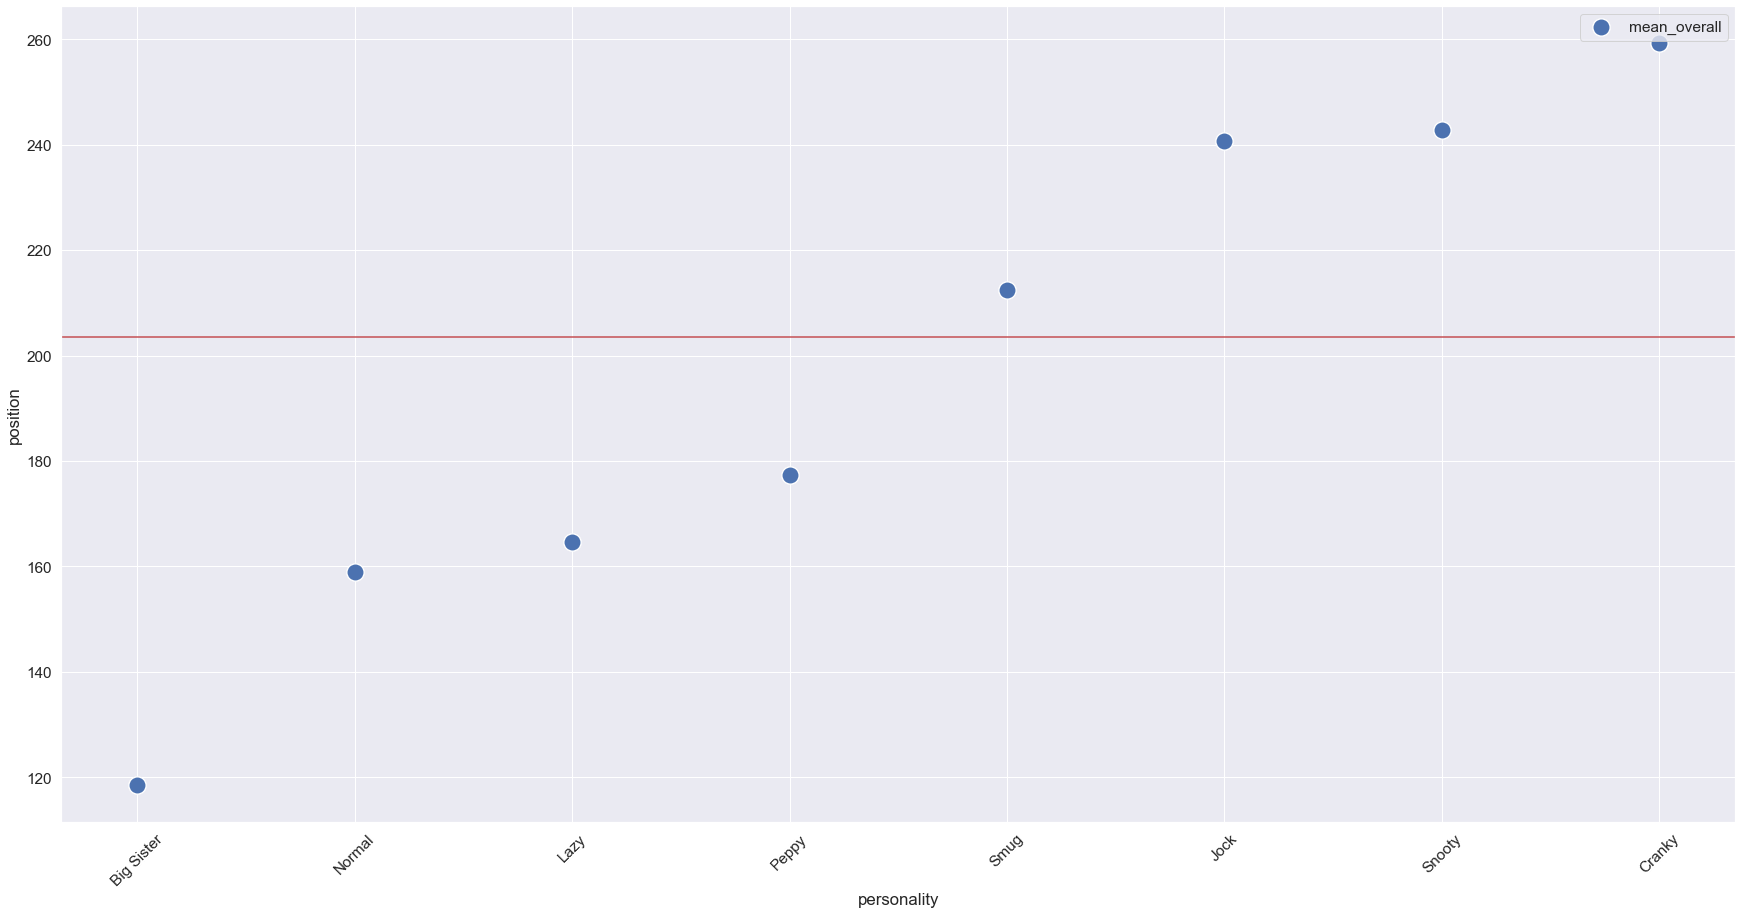

In [28]:
plt.figure(figsize=(30,15))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='personality', y="position", data=personality_ranking,label='mean_overall', s=300)

In [29]:
hobby_ranking = train.groupby('hobby').mean()['position'].to_frame().reset_index().sort_values('position')

In [30]:
hobby_ranking

,hobby,position
4,Nature,166.47
5,Play,189.92
0,Education,192.39
3,Music,201.40
1,Fashion,226.59
2,Fitness,249.71


In [31]:
def trait_means(train):
    for trait in train.columns:
       trait_ranking= train.groupby(trait).mean()['position'].to_frame().reset_index().sort_values('position')

In [74]:
def trait_means(train):
    results = []

    for col in train.drop(columns = 'position').columns:
        col= train.groupby(col).mean()['position'].to_frame().reset_index().sort_values('position')
        results.append(col)
    return results


In [75]:
trait_means(train)[1]

,species,position
25,Octopus,25.50
9,Deer,69.00
5,Cat,81.07
34,Wolf,81.40
15,Goat,114.00
29,Rabbit,136.44
10,Dog,143.33
32,Squirrel,164.43
17,Hamster,171.14
8,Cub,171.80


In [76]:
len(trait_means(train))

11

In [77]:
lists = trait_means(train)

In [78]:
def trait_means_dicts(train):
    results = {}

    for col in train.drop(columns = 'position').columns:
        col= train.groupby(col).mean()['position'].to_frame().reset_index().sort_values('position')
        results.append(col)
    return results

In [79]:
trait_means_dicts(train)

AttributeError: 'dict' object has no attribute 'append'

In [82]:
def trait_means_dicts(train):
    df_dict = {}

    for col in train.drop(columns = 'position').columns:
        df= train.groupby(col).mean()['position'].to_frame().reset_index().sort_values('position')
        df_dict[col] = df
    return df_dict

In [83]:
trait_means_dicts(train)

{'tier':    tier             position
 0     1                 7.67
 1     2                29.08
 2     3                56.62
 3     4               100.17
 4     5               184.64
 5     6               331.35,
 'species':       species             position
 25    Octopus                25.50
 9        Deer                69.00
 5         Cat                81.07
 34       Wolf                81.40
 15       Goat               114.00
 29     Rabbit               136.44
 10        Dog               143.33
 32   Squirrel               164.43
 17    Hamster               171.14
 8         Cub               171.80
 31      Sheep               175.71
 13   Elephant               180.25
 30      Rhino               183.25
 21      Koala               185.20
 23     Monkey               191.83
 2        Bear               200.29
 27    Penguin               201.22
 7         Cow               205.67
 26    Ostrich               211.67
 14       Frog               234.00
 11       Duck

In [87]:
trait_means_dicts(train)['tier']

,tier,position
0,1,7.67
1,2,29.08
2,3,56.62
3,4,100.17
4,5,184.64
5,6,331.35


In [88]:
list(trait_means_dicts(train))

['tier',
 'species',
 'gender',
 'personality',
 'hobby',
 'favorite_song',
 'style_1',
 'style_2',
 'color_1',
 'color_2',
 'is_successful']

<AxesSubplot:xlabel='species', ylabel='position'>

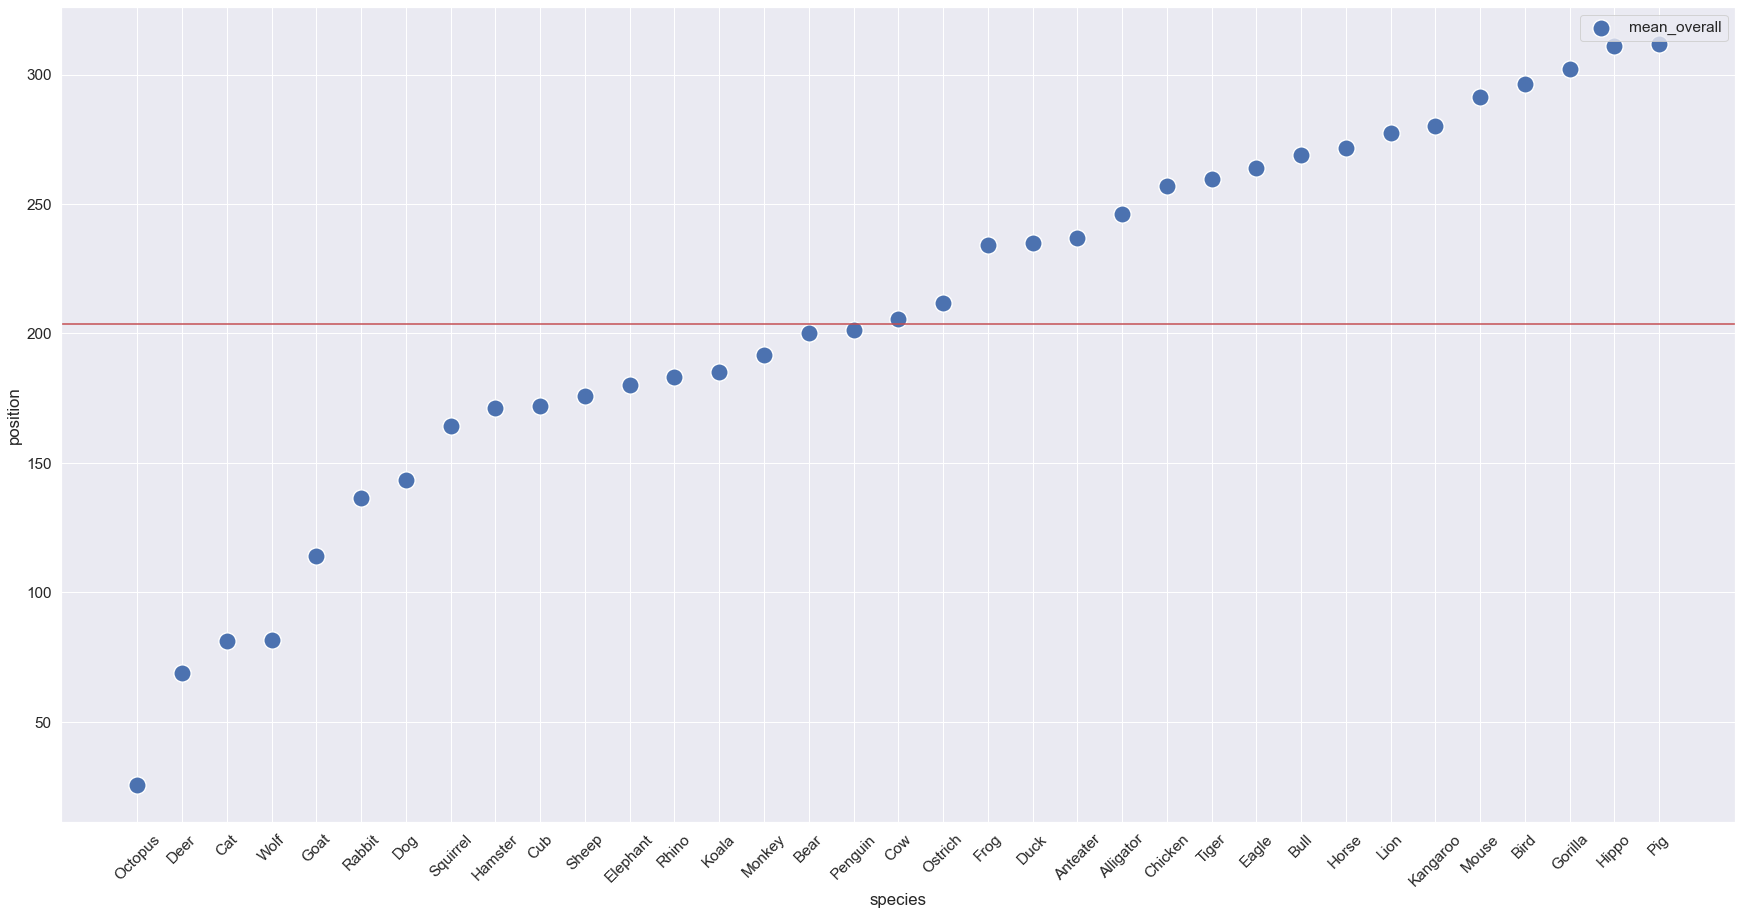

In [91]:
plt.figure(figsize=(30,15))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.scatterplot(x='species', y="position", data=trait_means_dicts(train)['species'],label='mean_overall', s=300)

In [ ]:
plt.figure(figsize=(15,5))
sns.set(font_scale=1.4)
plt.xticks(rotation=45)
plt.axhline(overall_mean, color='r')
sns.boxplot(x='gender', y="position", data=train)

# make 2 pie charts. one for successful and one for unsuccessful each with the species